In [1]:
#
import numpy as np
import os, sys
import matplotlib.pyplot as plt

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_sweep_whole, getBGSbits
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg
from cuts import getGeoCuts, get_bgs, flux_to_mag
from QA import getStats, flow

import healpy as hp
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
import astropy.units as units
import fitsio
from astropy.table import Table

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [3]:
dr8pix     = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
dr9mpix = '/global/cfs/cdirs/desi/target/catalogs/dr9m/0.42.0/pixweight/main/resolve/bright/pixweight-bright.fits'

#survey = 'south' #is either south (DECaLS+DES) or north (BASS/MzLS)
version = '0.1.0'
filesdir = '/global/cscratch1/sd/qmxp55/bgstargets_output/'

Nranfiles = 3
ranfiledens = 5000 #density of each random file
TotRanDens = Nranfiles * ranfiledens

patch = None #[174., 186., -3., 2.]
reg = 'north' #'south', 'north', 'decals', 'des', 'svfields'
dr = 'dr9m'
#version = '2.0'
if dr == 'dr9d': Nranfiles = 20 # because the randoms for dr9d have a density of 100000 = 5000*20
dec_resol_ns = 32.375

# for healpy
if dr[:3] == 'dr8': pixfile = dr8pix
elif dr[:3] == 'dr9': pixfile = dr9mpix
    
hdr          = fits.getheader(pixfile,1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

## catalogue

In [3]:

sweep_n_file = '/global/cscratch1/sd/qmxp55/bgstargets_output/%s/0.1.0/bgstargets-north.npy' %(dr)
extra_n_file = '/global/cscratch1/sd/qmxp55/bgstargets_output/%s/0.1.0/extra-north_n256.npy' %(dr)

%time sweep_n = np.load(sweep_n_file)
%time extra_n = np.load(extra_n_file)

#resolve for north/south and select only BGS targets
keep_n = (sweep_n['DEC'] > dec_resol_ns) & (extra_n['b'] > 0)

cat = sweep_n[keep_n]
extra = extra_n[keep_n]


CPU times: user 4.73 ms, sys: 11.2 s, total: 11.2 s
Wall time: 11.4 s
CPU times: user 0 ns, sys: 2.11 s, total: 2.11 s
Wall time: 2.24 s


In [4]:
del sweep_n, extra_n

In [5]:
#load catalogues
if dr == 'dr9sv': N = 1
else: N = Nranfiles
    
%time randoms = np.load(filesdir+dr+'/'+dr+'_random_N'+str(N)+'.npy', mmap_mode='r+')
%time ran_ex = np.load(filesdir+dr+'/'+'extra_random_N'+str(N)+'_n256.npy', mmap_mode='r+')

CPU times: user 3.92 ms, sys: 3.78 ms, total: 7.7 ms
Wall time: 51.7 ms
CPU times: user 552 µs, sys: 5.37 ms, total: 5.92 ms
Wall time: 53.9 ms


In [6]:
catinreg = (extra['desi']) & (extra[reg])
catindesi = extra['desi']

### randoms

In [7]:
hppix_ran = ran_ex['hppix']
ranindesi = ran_ex['desi']
raninreg = (ran_ex[reg]) & (ran_ex['desi'])

In [8]:
#bgsmask = bgsmask()
rancuts = getGeoCuts(randoms, randoms=True)

## Get BGS scenarios

====== Generating HPPIX dict ======
nominal area and density: 	 4492.67 [sq.deg] 	 1353.97 [objects/sq.deg]
====== Computing WEIGHTS ======
nominal weights coeff: 	 b=0, m=0
====== Assignin WEIGHTS for each target ======
CPU times: user 692 µs, sys: 691 µs, total: 1.38 ms
Wall time: 705 µs
CPU times: user 3.57 s, sys: 210 ms, total: 3.78 s
Wall time: 3.58 s
====== save to file ======
====== Generating HPPIX dict ======
no_LG_no_fracs area and density: 	 4492.67 [sq.deg] 	 1396.61 [objects/sq.deg]
====== Computing WEIGHTS ======
no_LG_no_fracs weights coeff: 	 b=0, m=0
====== Assignin WEIGHTS for each target ======
CPU times: user 15 ms, sys: 15 ms, total: 30.1 ms
Wall time: 15 ms
CPU times: user 4.11 s, sys: 181 ms, total: 4.29 s
Wall time: 4.11 s
====== save to file ======
====== Generating HPPIX dict ======
new_fracs_no_LG area and density: 	 4492.67 [sq.deg] 	 1373.43 [objects/sq.deg]
====== Computing WEIGHTS ======
new_fracs_no_LG weights coeff: 	 b=0, m=0
====== Assignin WEIGHTS f

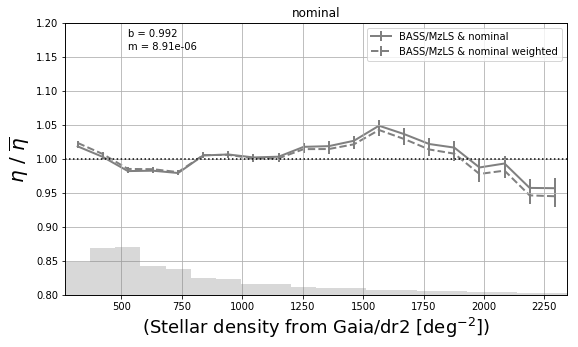

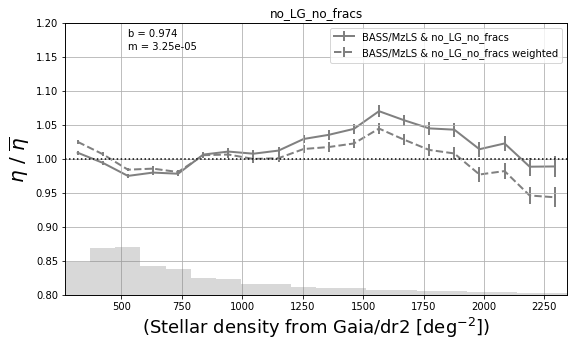

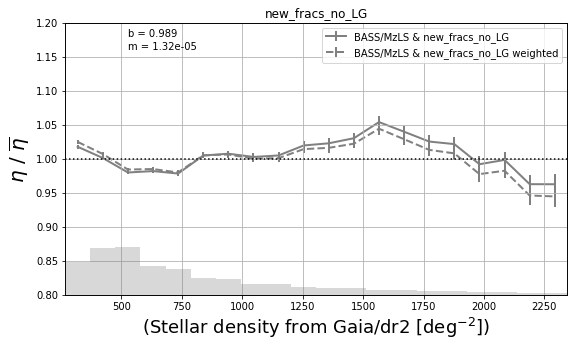

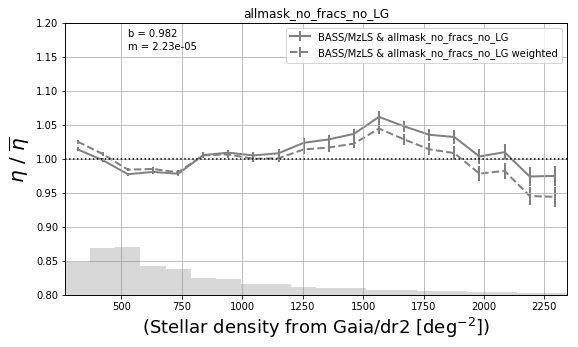

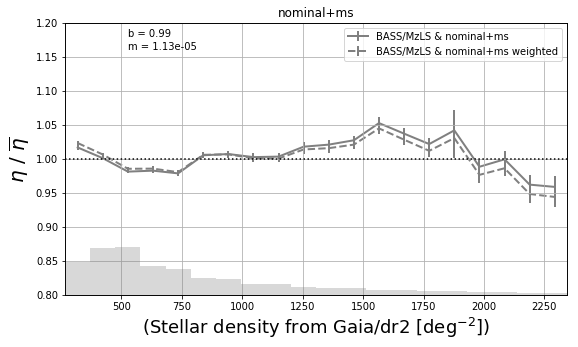

In [14]:
#
from cuts import bgsbut
from io_ import bgsmask
import pandas as pd
from astropy.table import Table

from QA import mollweide, mycmap, plot_sysdens
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib

bgsbut_fracs_but_lg = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM', 'QC_FI', 'QC_FF', 'LG'], bgsmask=bgsmask(), rlimit=20)

fracs_re = np.ones_like(cat, dtype=bool)
for i in (14,15,16): 
    fracs_re &= ((cat['BGSBITS'] & 2**(i)) != 0)

bgs_sce = {}
bgs_sce['nominal'] = ((cat['BGSBITS'] & 2**(20)) != 0)
bgs_sce['no_LG_no_fracs'] = bgsbut_fracs_but_lg
bgs_sce['new_fracs_no_LG'] = (bgsbut_fracs_but_lg) & (fracs_re)
bgs_sce['allmask_no_fracs_no_LG'] = (bgsbut_fracs_but_lg) & (((cat['BGSBITS'] & 2**(4)) != 0))
bgs_sce['nominal+ms'] = ((cat['BGSBITS'] & 2**(20)) != 0) & ((cat['BGSBITS'] & 2**(1)) != 0)

ws = {}
sys = {}
sys_w = {}
hpdicts = {}

for key, val in zip(bgs_sce.keys(), bgs_sce.values()):
    
    cati = cat[val]
    extrai = extra[val]
    catinregi = catinreg[val]
    catindesii = catindesi[val]
    
    if key == 'allmask_no_fracs_no_LG': maskrand = ((rancuts['BS']) & (rancuts['GC']) & (rancuts['nobs']) & (rancuts['allmask']) & (raninreg))
    elif key == 'nominal+ms': maskrand = ((rancuts['BS']) & (rancuts['GC']) & (rancuts['nobs']) & (rancuts['MS']) & (raninreg))
    else: maskrand = ((rancuts['BS']) & (rancuts['GC']) & (rancuts['nobs']) & (raninreg))
        
    print('====== Generating HPPIX dict ======')
    
    #dic with default BGS selection and in DESI footprint
    hpdict = get_dict(cat=cati, pixmapfile=pixfile, hppix_ran=hppix_ran, hppix_cat=extrai['hppix'], 
                      maskrand=maskrand, maskcat=(catinregi), Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=catindesii, 
                                namesels={key:val[val]}, galb=extrai['b'], log=False, survey='custom', ranfiledens=ranfiledens)
    
    hpdicts[key] = hpdict
    
    print('%s area and density: \t %.2f [sq.deg] \t %.2f [objects/sq.deg]' %(key, hpdict['bgsarea_north'], hpdict['dens_%s_north' %(key)]))
    
    print('====== Computing WEIGHTS ======')
    
    isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0)
    namesel = key
    syst='stardens'

    fig    = plt.figure(figsize=(9,5))
    gs     = gridspec.GridSpec(1,1,hspace=0.30,wspace=0.25)
    
    b0, m0, sysi, sysi_w = plot_sysdens(hpdicttmp=hpdict, namesels=[namesel], regs=['north'], syst=syst, mainreg=isdesi, xlim=None, n=0, nx=20, 
             clip=True, denslims=False, ylab=True, weights=True, fig=fig, gs=gs, label=True, title=key, overbyreg=True, percentiles=None)

    print('%s weights coeff: \t b=%i, m=%i' %(key, b0, m0))
    
    wsi = 1./((m0)*hpdict['stardens'] + b0)
    ws[key] = wsi
    sys[key] = sysi
    sys_w[key] = sysi_w
    
    print('====== Assignin WEIGHTS for each target ======')
    
    %time s = pd.Series(extrai['hppix'])
    %time d = s.groupby(s).groups
    
    DENS = np.zeros_like(cati['RA'])
    WS_north = DENS.copy()
    STARDEN = DENS.copy()
    
    hpdens = (hpdict['south_n%s' %(key)] + hpdict['north_n%s' %(key)] ) / (pixarea * hpdict['bgsfracarea'])
    
    for npixid, catids in zip(d.keys(), d.values()):
        DENS[catids] = hpdens[npixid]
        STARDEN[catids] = hpdict['stardens'][npixid]
        WS_north[catids] = wsi[npixid]
    
    print('====== save to file ======')
    
    tab = Table()
    cols = ['TYPE','RA','DEC','GMAG','RMAG','ZMAG', 'MASKBITS','BGSBITS']

    for col in cols:
        tab[col] = cati[col]

    for col in ['b','des','decals','north','desi','south']:
        tab[col] = extrai[col]

    tab['DENS'] = DENS
    tab['WS_north'] = WS_north
    tab['STARDEN'] = STARDEN
    tab['bgs'] = val[val]

    if True:
    # save astropy table as npy file
        dest = '/global/cscratch1/sd/qmxp55/bgstargets_output/%s/clustering/%s_%s' %(dr, reg, key)
        np.save(dest, tab)
    

## Get RANDOMS for BGS scenarios with STARDENS

In [15]:
# match associated target density for each object

s = pd.Series(ran_ex['hppix'])
d = s.groupby(s).groups

STARDEN_ran = np.zeros_like(randoms['RA'])

#
for npixid, catids in zip(d.keys(), d.values()):
    STARDEN_ran[catids] = hpdicts['nominal']['stardens'][npixid]


In [18]:
#
maskrands = {'nominal':((rancuts['BS']) & (rancuts['GC']) & (rancuts['nobs'])),
             'nominal+allmask':((rancuts['BS']) & (rancuts['GC']) & (rancuts['nobs']) & (rancuts['allmask'])),
             'nominal+ms': ((rancuts['BS']) & (rancuts['GC']) & (rancuts['nobs']) & (rancuts['MS']))}

for key, val in zip(maskrands.keys(), maskrands.values()):
    
    tabran = Table()

    mask = val

    tabran['RA'], tabran['DEC'] = randoms['RA'][mask], randoms['DEC'][mask]
    tabran['MASKBITS'] = randoms['MASKBITS'][mask]

    for col in ['b','des','decals','north','desi','south']:
        tabran[col] = ran_ex[col][mask]

    tabran['STARDEN'] = STARDEN_ran[mask]

    # save astropy table as npy file
    dest = '/global/cscratch1/sd/qmxp55/bgstargets_output/%s/clustering/randoms_%s_%s' %(dr, reg, key)
    np.save(dest, tabran)
    

In [19]:
#fix permissions
#chgrp -R desi  /global/cscratch1/sd/qmxp55/bgstargets_output/dr9m
#chmod -R g+rX  /global/cscratch1/sd/qmxp55/bgstargets_output/dr9m

Variable              Type          Data/Info
---------------------------------------------
DENS                  ndarray       6494781: 6494781 elems, type `float64`, 51958248 bytes (49.551246643066406 Mb)
N                     int           3
Nranfiles             int           3
STARDEN               ndarray       6494781: 6494781 elems, type `float64`, 51958248 bytes (49.551246643066406 Mb)
STARDEN_ran           memmap        [ 876.92785645  247.82743<...>70014954\n  781.60961914]
SkyCoord              ABCMeta       <class 'astropy.coordinat<...>sky_coordinate.SkyCoord'>
Table                 type          <class 'astropy.table.table.Table'>
TotRanDens            int           15000
WS_north              ndarray       6494781: 6494781 elems, type `float64`, 51958248 bytes (49.551246643066406 Mb)
b0                    float64       0.9898924756034334
bgs_sce               dict          n=5
bgsbut                function      <function bgsbut at 0x2aaadfc85400>
bgsbut_fracs_but_lg   

# Sanity checks

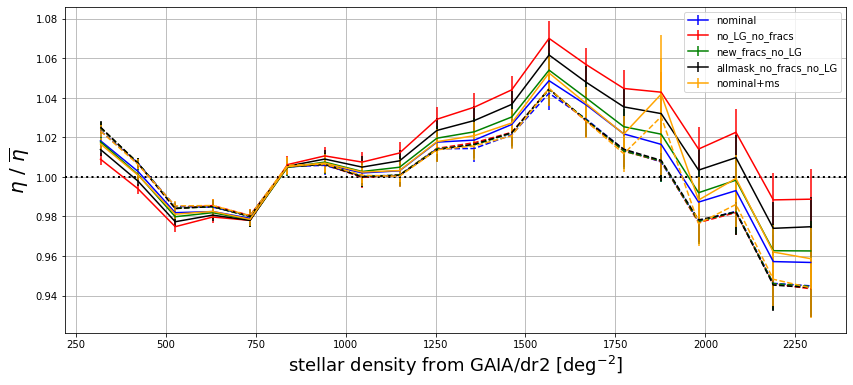

In [29]:
#
#stacking systematics
fig = plt.figure(figsize=(14,6))
colors = ['blue', 'red', 'green', 'k', 'orange']
for num, key in enumerate(sys.keys()):
    
    plt.errorbar(sys[key][0], sys[key][1], sys[key][2], ls='-', color=colors[num], label=key)
    plt.errorbar(sys_w[key][0], sys_w[key][1], sys_w[key][2], ls='--', color=colors[num])
    
plt.axhline(1, ls=':', c='k', lw=2)
plt.ylabel(r'$\eta$ / $\overline{\eta}$',fontsize=20)
plt.xlabel('stellar density from GAIA/dr2 [deg$^{-2}$]',fontsize=18)
plt.grid()
plt.legend()

fig.savefig('stellar_dens_syst_%s_%s_%s.png' %(dr, reg, key), bbox_inches = 'tight', pad_inches = 0)


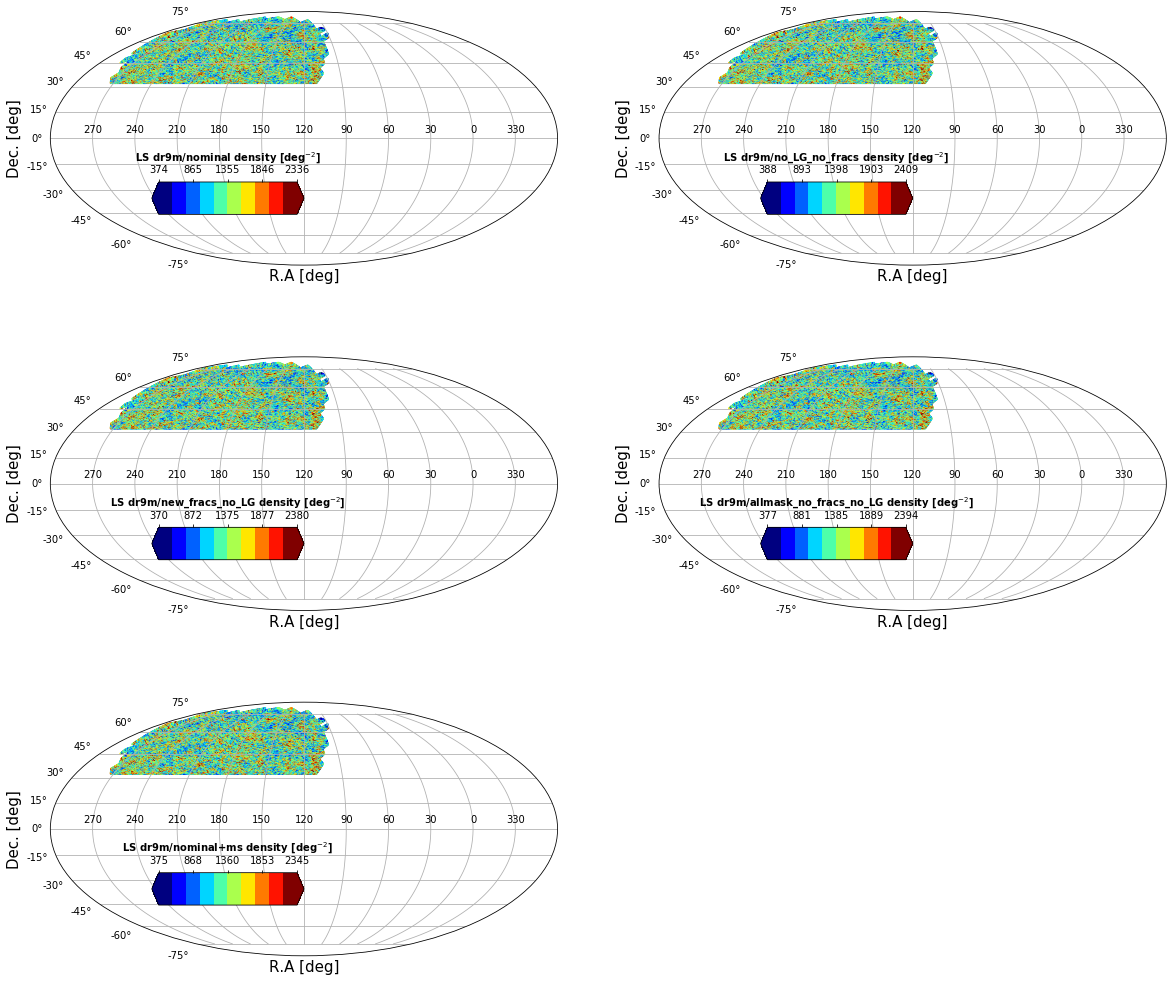

In [28]:
#witbgs_scets
fig = plt.figure(figsize=(20, 18))
gs = gridspec.GridSpec(3,2)
    
org          = 120  # centre ra for mollweide plots
projection   = 'mollweide'
cm = mycmap(matplotlib.cm.jet, 10,0,1)
cmr= mycmap(matplotlib.cm.jet_r,10,0,1)
    
for num, key, val in zip(range(len(hpdicts.keys())), hpdicts.keys(), hpdicts.values()):
    
    #plt.title(r'%s' %(key), size=18)
    mollweide(hpdict=val, namesel=key, reg='north', projection=projection, n=num, org=org, cm=cm, fig=fig, gs=gs, cval=None, dr=dr)

fig.savefig('skymap_dens_%s_%s_%s.png' %(dr, reg, key), bbox_inches = 'tight', pad_inches = 0)

Text(0, 0.5, 'Dec.')

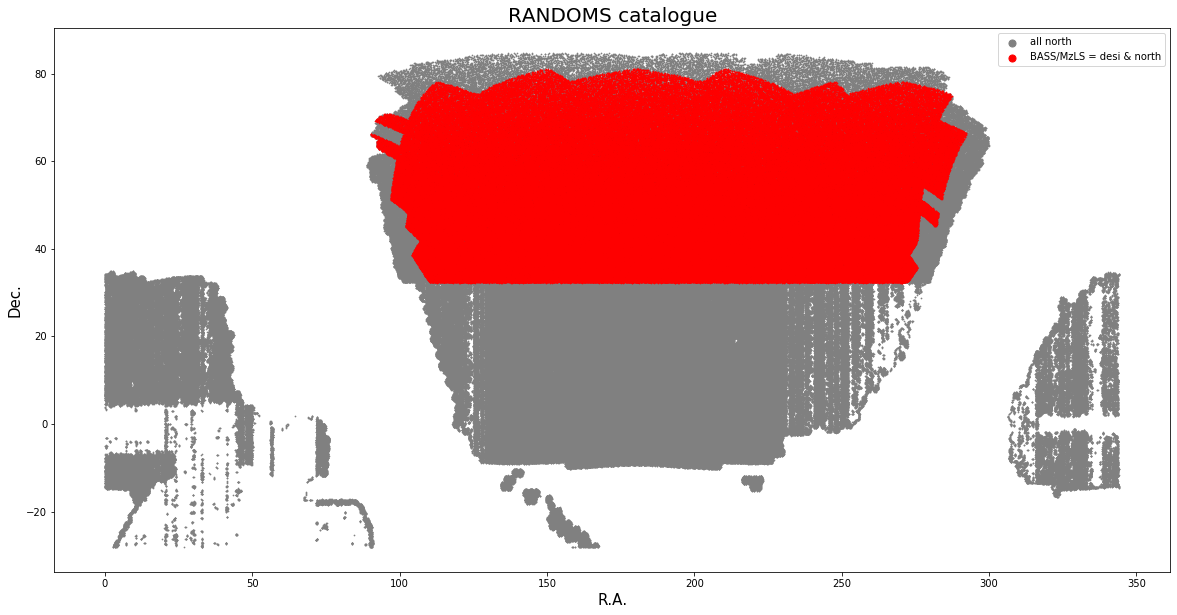

In [23]:
#
tabran = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9m/clustering/randoms_north_nominal.npy')

plt.figure(figsize=(20,10))

mask2 = tabran['STARDEN'] < 1000
maskn = (tabran['north']) & (tabran['desi'])
N = 200

plt.scatter(tabran['RA'][::N], tabran['DEC'][::N], s=0.5, c='gray', label='all north')
plt.scatter(tabran['RA'][maskn][::N], tabran['DEC'][maskn][::N], s=0.5, c='r', label='BASS/MzLS = desi & north')

plt.title('RANDOMS catalogue', size=20)

lgnd = plt.legend()
[handle.set_sizes([50]) for handle in lgnd.legendHandles]

plt.xlabel(r'R.A.', size=15)
plt.ylabel(r'Dec.', size=15)

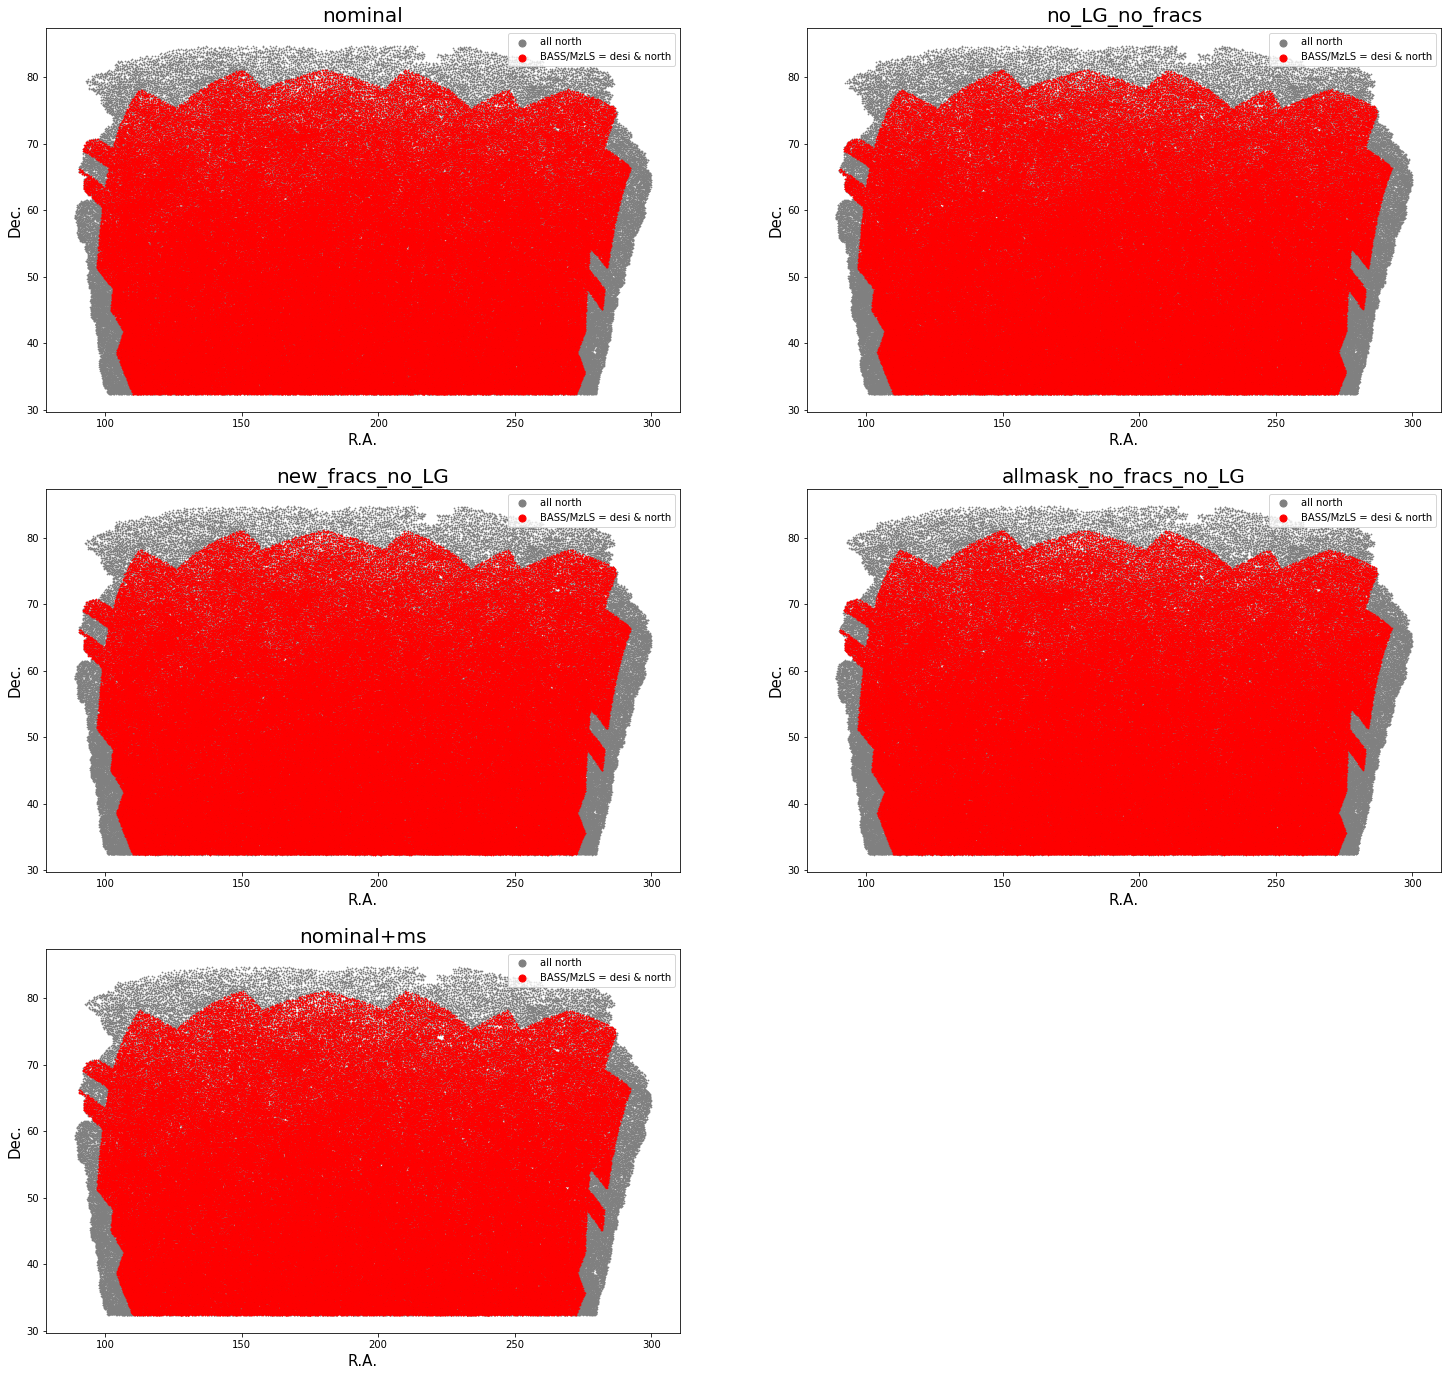

In [26]:
plt.figure(figsize=(25,24))

for num, key in enumerate(bgs_sce.keys()):
    
    tab = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9m/clustering/north_%s.npy' %(key))

    N = 30
    mask2 = tab['STARDEN'] < 1000
    maskn = (tab['north']) & (tab['desi'])

    plt.subplot(3,2,num+1)
    plt.scatter(tab['RA'][::N], tab['DEC'][::N], s=0.5, c='gray', label='all north')
    plt.scatter(tab['RA'][maskn][::N], tab['DEC'][maskn][::N], s=0.5, c='r', label='BASS/MzLS = desi & north')

    plt.title(r'%s' %(key), size=20)

    lgnd = plt.legend()
    [handle.set_sizes([50]) for handle in lgnd.legendHandles]

    plt.xlabel(r'R.A.', size=15)
    plt.ylabel(r'Dec.', size=15)


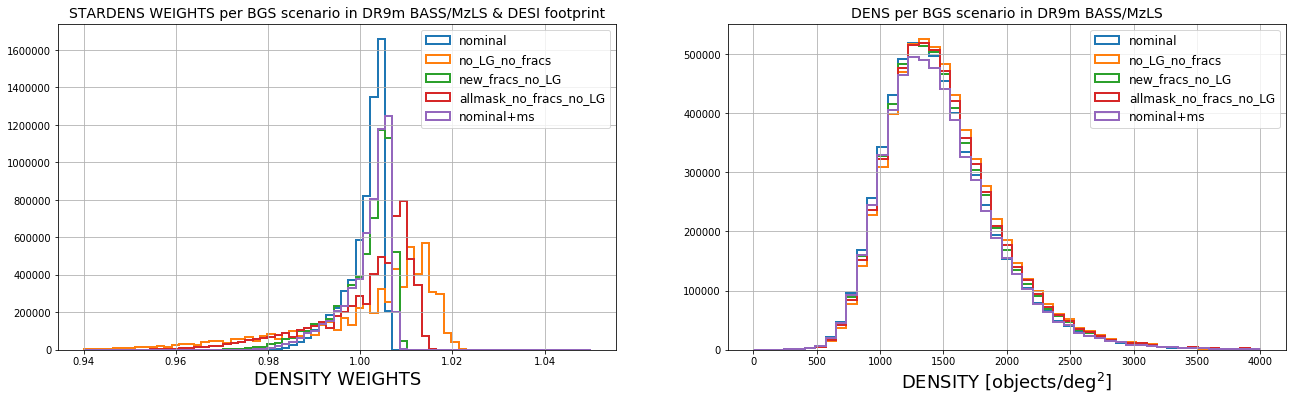

In [30]:
#
fig = plt.figure(figsize=(22, 6))

for num, key in enumerate(bgs_sce.keys()):
    
    tab = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9m/clustering/north_%s.npy' %(key))
    mask = (tab['north']) & (tab['desi'])
    finite = np.isfinite(tab['DENS'])

    bins = np.linspace(.94, 1.05, 70)
    bins2 = np.linspace(0, 4000, 50)
    
    plt.subplot(1,2,1)
    plt.title('STARDENS WEIGHTS per BGS scenario in DR9m BASS/MzLS & DESI footprint', size=14)
    plt.hist(tab['WS_north'][mask], bins=bins, histtype='step', lw=2, label=key)
    plt.legend(fontsize=12)
    plt.grid()
    plt.xlabel(r'DENSITY WEIGHTS', size=18)
    
    plt.subplot(1,2,2)
    plt.title('DENS per BGS scenario in DR9m BASS/MzLS', size=14)
    plt.hist(tab['DENS'][(mask) & (finite)], bins=bins2, histtype='step', lw=2, label=key)
    plt.legend(fontsize=12)
    plt.grid()
    plt.xlabel(r'DENSITY [objects/deg$^{2}$]', size=18)
    
fig.savefig('weights_%s_%s_%s.png' %(dr, reg, key), bbox_inches = 'tight', pad_inches = 0)
    

# Repeating above with 2X the BS masking radii of DR9

- [X] Create the `maskbitsources` file.

```python

patch = None
maskbitsources = get_sweep_whole(patch=patch, dr='%s-%s' %(dr, reg), rlimit=None, maskbitsource=True, bgsbits=False, 
                opt='2', sweepdir='/global/cscratch1/sd/qmxp55/bgstargets_output/%s/' %(dr))
```


- [X] get the BS stars
- [] mask arond them for master catalogue (cat) and randoms (randoms). If this take a long time, save files to dr9 output directory
- [] Run script to generate the catalogues for the different scenariis and the randoms as well.
- [] generate the plots.
    

In [4]:
maskbitsources = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/%s/%s-%s_sweep_whole_maskbitsource.npy' 
                         %(dr, dr, reg), mmap_mode='r+')

In [5]:
from io_ import get_bsmask
stars = get_bsmask(maskbitsources)

1769 nearby objects
450307 Bright Stars


In [6]:
#np.save('/global/cscratch1/sd/qmxp55/bgstargets_output/%s/stars_TYCHO_GAIA_13' %(dr), stars)

In [24]:
#
hppix = hp.ang2pix(nside,(90.-stars['DEC'])*np.pi/180.,stars['RA']*np.pi/180.,nest=True)
print('healpix DONE...')
stars_desi = get_reg(reg='desi', hppix=hppix)
stars_reg = get_reg(reg=reg, hppix=hppix)


healpix DONE...


In [25]:
#Dustin_radii's
mag = np.linspace(0, 20, 50)
BS_radii = [] #DR8
new_BS_radii = [] #DR9
for i,j in enumerate(mag):
    BS_radii.append([j, np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])
    new_BS_radii.append([j, 0.5 * np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])

### Use code below to check footprint in catalogue and star catalogue

```python
plt.figure(figsize=(20, 12))
sm = (stars_desi) & (stars_reg)
cm = (catindesi) & (catinreg)

plt.subplot(2,1,1)
plt.scatter(cat['RA'][cm][::20], cat['DEC'][cm][::20], s=1, label='cat')

plt.subplot(2,1,2)
plt.scatter(stars['RA'][sm][::5], stars['DEC'][sm][::5], s=1, label='stars')
```

### Use code below to get custom masking around Bright Stars in Catalogue and Randoms
Approx run time for catalogue is $\sim 200$ sec, and $\sim 1000$ sec for randoms.

```python 
#
from QA import circular_mask_radii_func
from io_ import query_catalog_mask

#=====================================
#==== Custom masking on CATALOGUE ====
#=====================================

BS_t = query_catalog_mask(cat['RA'], cat['DEC'], stars, BS_radii, nameMag='MAG', diff_spikes=False, 
                             length_radii=None, widht_radii=None, return_diagnostics=True, bestfit=False, log=False)
#
new_BS_t = query_catalog_mask(cat['RA'], cat['DEC'], stars, new_BS_radii, nameMag='MAG', diff_spikes=False, 
                             length_radii=None, widht_radii=None, return_diagnostics=True, bestfit=False, log=False)

#masking radius for each object cloosest stars in cat
mask_radii = circular_mask_radii_func(BS_t[1]['w1_source'], BS_radii, bestfit=False)
#masking radius reescaled for each object
mask_radii_res = BS_t[1]['d2d_source']/mask_radii

tab = Table()
tab['dr8'] = BS_t[0]
tab['dr9'] = new_BS_t[0]

file_cat_radiis = '/global/cscratch1/sd/qmxp55/bgstargets_output/%s/%s-%s_custom_radi_catalogue.npy' %(dr, dr, reg)
np.save(file_cat_radiis, tab)

#=====================================
#==== Custom masking on RANDOMS ======
#=====================================

BS_t_ran = query_catalog_mask(randoms['RA'], randoms['DEC'], stars, BS_radii, nameMag='MAG', diff_spikes=False, 
                             length_radii=None, widht_radii=None, return_diagnostics=False, bestfit=False, log=False)
#
new_BS_t_ran = query_catalog_mask(randoms['RA'], randoms['DEC'], stars, new_BS_radii, nameMag='MAG', diff_spikes=False, 
                             length_radii=None, widht_radii=None, return_diagnostics=False, bestfit=False, log=False)


tab_ran = Table()
tab_ran['dr8'] = BS_t_ran
tab_ran['dr9'] = new_BS_t_ran

file_ran_radiis = '/global/cscratch1/sd/qmxp55/bgstargets_output/%s/%s-%s_custom_radi_randoms.npy' %(dr, dr, reg)
np.save(file_ran_radiis, tab_ran)
```

In [65]:
sm = (stars_desi) & (stars_reg)
cm = (catindesi) & (catinreg)
bgsbut_bs = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['BS'], bgsmask=bgsmask(), rlimit=20)
BS = (cat['MASKBITS'] & 2**1)!=0

In [66]:
print('Tot. masked by Custom DR8 radii: \t %i '%(BS_t[0][cm].sum()))
print('Tot. masked by Custom DR9 radii: \t %i '%(new_BS_t[0][cm].sum()))
print('Tot. masked by official DR9 radii: \t %i '%(BS[cm].sum()))
print('--------')
print('Missed by Custom DR9: \t %i' %(((BS) & (~new_BS_t[0]) & (cm)).sum()))
print('\t of which in BGS: \t %i' %(((BS) & (~new_BS_t[0]) & (cm) & (bgsbut_bs)).sum()))

Tot. masked by Custom DR8 radii: 	 1795737 
Tot. masked by Custom DR9 radii: 	 759151 
Tot. masked by official DR9 radii: 	 815348 
--------
Missed by Custom DR9: 	 59604
	 of which in BGS: 	 3883


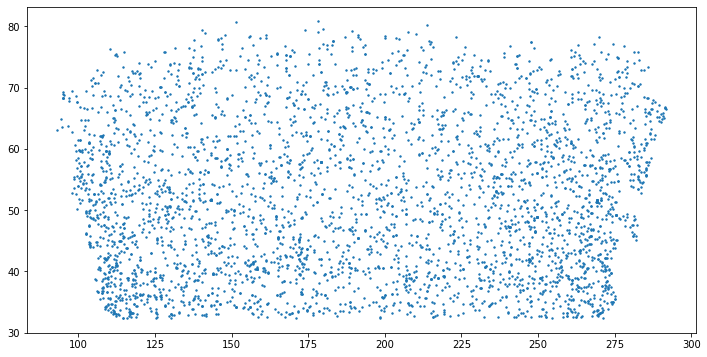

In [67]:
from cuts import bgsbut
plt.figure(figsize=(12,6))

mask =(BS) & (~new_BS_t[0]) & (cm) & (bgsbut_bs)
plt.scatter(cat['RA'][mask], cat['DEC'][mask], s=2, label='cat')

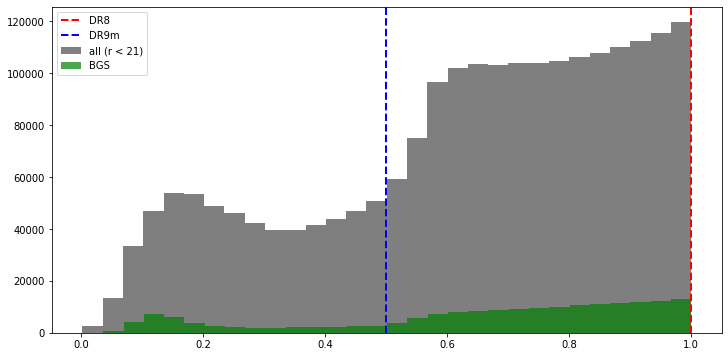

In [62]:
plt.figure(figsize=(12,6))
plt.hist(mask_radii_res[mask_radii_res > 0], 30, alpha=0.5, color='k', label='all (r < 21)')
plt.hist(mask_radii_res[(mask_radii_res > 0) & (bgsbut_bs)], 30, alpha=0.7, color='g', label='BGS')
plt.axvline(1, lw=2, ls='--', color='r', label='DR8')
plt.axvline(0.5, lw=2, ls='--', color='b', label='DR9m')
plt.legend()
plt.show()

Hi all,

Before proceding to generate a catalogue with a custom masking radii around bright stars I want to share I found some differences in the number of rejected objects by official BS mask (the one defined by the `MASKBITS` in the SWEEPS with bit=1) and the custom mask I implemented. In total, using custom masking in DR9m we miss (or we don't mask) 59604 objects that the official masking masks. This represents ~7% out of the total objects masked by the official mask with r < 21. Some numbers below.

Tot. masked by Custom DR9 radii: 	 759151 
Tot. masked by official DR9 radii: 	 815348 
--------
Missed by Custom DR9: 	 59604
	 of which in BGS: 	 3883
     Tot. masked by Custom DR9 radii: 	 759151 
Tot. masked by official DR9 radii: 	 815348 
--------
Missed by Custom DR9: 	 59604
	 of which in BGS: 	 3883
I think we should check this before running any clustering analysis. In plots below we have the sky positions of these 7% missing objects and then we have a histogram of the objects masked by the custom BS mask in gray (objects have the upper limit of r < 21), and in green we have the BGS out of the gray ones, meaning this last ones wont be masked out if using the Custom BS mask. X-axis scale is the distance reescaled to the masking radius to the closest star for each object. Red and blue dashed lines shows the masking radii using in DR8 and in DR9m respectively.